In [ ]:
import deepdish as dd
import numpy as np

# Read the entire file
h5_file_path="/gchm/cd4_chrombpnet/chrombpnet_model_b7/variant_contribution_scores/perfold/fold_0/cd4_tcells_AJ_common_variants.shap.variant_shap.counts.h5"
data = dd.io.load(h5_file_path)

In [6]:
data

{'alleles': array([0, 0, 0, ..., 1, 1, 1]),
 'projected_shap': {'seq': array([[[ 0.e+00,  0.e+00, -0.e+00, ...,  0.e+00,  0.e+00,  0.e+00],
          [-0.e+00, -0.e+00, -0.e+00, ..., -0.e+00,  0.e+00,  0.e+00],
          [ 0.e+00,  0.e+00, -0.e+00, ..., -0.e+00,  0.e+00,  0.e+00],
          [ 0.e+00,  0.e+00, -0.e+00, ...,  0.e+00,  0.e+00,  0.e+00]],
  
         [[-0.e+00,  0.e+00, -0.e+00, ...,  0.e+00, -0.e+00,  0.e+00],
          [ 0.e+00, -0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -0.e+00],
          [ 0.e+00, -0.e+00, -0.e+00, ...,  0.e+00, -0.e+00, -0.e+00],
          [ 0.e+00, -0.e+00,  0.e+00, ...,  6.e-08,  0.e+00, -0.e+00]],
  
         [[ 0.e+00,  0.e+00, -0.e+00, ..., -0.e+00,  0.e+00,  0.e+00],
          [ 0.e+00,  0.e+00, -0.e+00, ...,  0.e+00,  0.e+00, -0.e+00],
          [ 0.e+00,  0.e+00, -0.e+00, ...,  0.e+00,  0.e+00,  0.e+00],
          [ 0.e+00, -0.e+00, -0.e+00, ...,  0.e+00,  0.e+00,  0.e+00]],
  
         ...,
  
         [[ 0.e+00,  0.e+00,  0.e+00, ..., -0.e+00

In [10]:
import deepdish as dd
import numpy as np
import matplotlib.pyplot as plt

def analyze_variant_blast_radius_from_deepdish(h5_file_path, variant_identifier, threshold=0.05, window_size=None):
    """
    Analyze the blast radius for a specific variant from a deepdish h5 file
    
    Parameters:
    -----------
    h5_file_path : str
        Path to the deepdish h5 file
    variant_identifier : str or int
        If str: The variant ID to analyze (e.g., "chr1_1013490_G_C")
        If int: The index of the variant in the h5 file (this is the variant index, not the allele index)
    threshold : float, optional
        Threshold for determining affected positions, default is 0.05
    window_size : int or tuple, optional
        Size of the window around the center to analyze and plot
        If int, uses symmetric window of size (center-window_size, center+window_size)
        If tuple of (left, right), uses window of (center-left, center+right)
        If None, uses the entire sequence
    
    Returns:
    --------
    blast_radius : int
        The calculated blast radius in base pairs
    """
    
    # Load the deepdish file
    data = dd.io.load(h5_file_path)
    
    # Extract data components
    variant_ids = data['variant_ids']
    alleles = data['alleles']
    shap_seq = data['shap']['seq']
    
    print(f"Loaded data with {len(variant_ids)} total entries")
    print(f"SHAP data shape: {shap_seq.shape}")
    print(f"Unique variants: {len(variant_ids) // 2}")  # Each variant has 2 alleles
    
    # Get variant ID or index based on the input
    if isinstance(variant_identifier, str):
        # We're looking for a variant ID
        # Convert to strings for comparison
        variant_ids_str = []
        for vid in variant_ids:
            if isinstance(vid, bytes):
                vid = vid.decode('utf-8')
            variant_ids_str.append(str(vid))
        
        # Find the variant ID
        if variant_identifier in variant_ids_str:
            variant_idx = variant_ids_str.index(variant_identifier)
            variant_id = variant_identifier
        else:
            # Look for partial matches (e.g., without allele number)
            matches = [i for i, v in enumerate(variant_ids_str) if variant_identifier in v]
            if matches:
                variant_idx = matches[0]
                variant_id = variant_ids_str[variant_idx]
                print(f"Using closest match: {variant_id}")
            else:
                raise ValueError(f"Variant ID '{variant_identifier}' not found")
    else:
        # Using numerical index - this is the variant index (not allele index)
        variant_idx = variant_identifier
        if 0 <= variant_idx < len(variant_ids):
            variant_id = variant_ids[variant_idx]
            if isinstance(variant_id, bytes):
                variant_id = variant_id.decode('utf-8')
        else:
            raise ValueError(f"Variant index {variant_identifier} out of range")
    
    # Calculate the allele indices
    # In this dataset format, each variant has 2 consecutive entries:
    # Even indices (0, 2, 4...) are for reference (alleles[i] = 0)
    # Odd indices (1, 3, 5...) are for alternate (alleles[i] = 1)
    
    # Find the actual variant index in the dataset (the one that corresponds to index in variant_ids)
    variant_idx_in_dataset = variant_idx
    
    # Calculate ref and alt indices for SHAP values
    # For each variant we have two rows in the alleles array (ref=0, alt=1)
    # Since there are exactly 3467 variants and 6934 rows, each variant must have exactly 2 alleles
    variant_pair_start = (variant_idx_in_dataset // 2) * 2  # Get the start of each variant pair
    
    # Find indices for reference and alternate alleles in the pair
    ref_variant_idx = None
    alt_variant_idx = None
    
    # Check the allele values for the current pair (should be 0 for ref, 1 for alt)
    if variant_pair_start < len(alleles) and variant_pair_start + 1 < len(alleles):
        first_allele = alleles[variant_pair_start]
        second_allele = alleles[variant_pair_start + 1]
        
        if first_allele == 0 and second_allele == 1:
            # Normal case: ref followed by alt
            ref_variant_idx = variant_pair_start
            alt_variant_idx = variant_pair_start + 1
        elif first_allele == 1 and second_allele == 0:
            # Reversed case: alt followed by ref
            ref_variant_idx = variant_pair_start + 1
            alt_variant_idx = variant_pair_start
        else:
            # Unexpected case, try to find closest ref/alt
            print(f"Warning: Unexpected allele values at indices {variant_pair_start}:{variant_pair_start+1}: {first_allele}, {second_allele}")
            # Default to pair start for ref and pair start+1 for alt
            ref_variant_idx = variant_pair_start
            alt_variant_idx = variant_pair_start + 1
    else:
        raise ValueError(f"Variant index {variant_identifier} does not have corresponding alleles")
    
    # Get the SHAP values
    # Each entry in shap_seq has shape (4, 2114) - 4 nucleotides, 2114 positions
    ref_profile = shap_seq[ref_variant_idx].sum(axis=0)  # Sum across nucleotide channels
    alt_profile = shap_seq[alt_variant_idx].sum(axis=0)  # Sum across nucleotide channels
    
    # Calculate absolute difference at each position
    diff_profile = np.abs(alt_profile - ref_profile)
    
    # Assume center position is in the middle of the sequence
    center_position = len(ref_profile) // 2
    
    # Apply window if specified
    if window_size is not None:
        if isinstance(window_size, tuple) and len(window_size) == 2:
            left_offset, right_offset = window_size
        elif isinstance(window_size, int):
            left_offset = right_offset = window_size
        else:
            raise ValueError("window_size must be an integer or a tuple of (left, right)")
        
        # Calculate window boundaries
        start_idx = max(0, center_position - left_offset)
        end_idx = min(len(ref_profile), center_position + right_offset + 1)
        
        # Slice profiles to the window
        ref_profile_window = ref_profile[start_idx:end_idx]
        alt_profile_window = alt_profile[start_idx:end_idx]
        diff_profile_window = diff_profile[start_idx:end_idx]
        
        # Adjust positions relative to center
        positions_window = np.arange(start_idx, end_idx)
        relative_positions_window = positions_window - center_position
        
        # Find affected positions within window
        affected_indices = np.where(diff_profile_window > threshold)[0]
        affected_positions = start_idx + affected_indices
    else:
        # Use full profiles
        ref_profile_window = ref_profile
        alt_profile_window = alt_profile
        diff_profile_window = diff_profile
        
        positions = np.arange(len(ref_profile))
        relative_positions_window = positions - center_position
        
        # Find all affected positions
        affected_positions = np.where(diff_profile > threshold)[0]
    
    # Calculate blast radius
    if len(affected_positions) > 0:
        min_affected = affected_positions.min()
        max_affected = affected_positions.max()
        blast_radius = max_affected - min_affected + 1
    else:
        blast_radius = 0
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Top plot: Reference and Alternate profiles
    ax1.plot(relative_positions_window, ref_profile_window, 'b-', label='Reference allele', linewidth=1.5)
    ax1.plot(relative_positions_window, alt_profile_window, 'r-', label='Alternate allele', linewidth=1.5)
    ax1.axvline(x=0, color='k', linestyle='--', linewidth=1, label='Variant position')
    ax1.set_xlabel('Distance from Variant (bp)')
    ax1.set_ylabel('SHAP Value')
    ax1.set_title(f'SHAP Profiles for Variant {variant_id}')
    ax1.legend()
    ax1.grid(alpha=0.3, linewidth=0.5)
    
    # Bottom plot: Difference profile with affected regions
    ax2.plot(relative_positions_window, diff_profile_window, 'g-', label='|Alt - Ref|', linewidth=1.5)
    ax2.axhline(y=threshold, color='orange', linestyle=':', linewidth=1, label=f'Threshold ({threshold})')
    ax2.axvline(x=0, color='k', linestyle='--', linewidth=1, label='Variant position')
    
    # Highlight affected regions
    if len(affected_positions) > 0:
        # Filter affected positions to those within our window
        if window_size is not None:
            window_affected = [pos for pos in affected_positions 
                              if start_idx <= pos < end_idx]
        else:
            window_affected = affected_positions
        
        if len(window_affected) > 0:
            affected_rel_positions = np.array(window_affected) - center_position
            max_diff = np.max(diff_profile_window)
            ax2.fill_between(
                affected_rel_positions, 
                0, 
                max_diff * 1.1,  # Extend slightly above maximum
                color='red', alpha=0.2, label='Affected region'
            )
    
    ax2.set_xlabel('Distance from Variant (bp)')
    ax2.set_ylabel('Absolute SHAP Difference')
    ax2.set_title(f'SHAP Difference Profile - Blast Radius: {blast_radius} bp')
    ax2.legend()
    ax2.grid(alpha=0.3, linewidth=0.5)
    
    # Set x-axis limits based on window size for both plots
    if window_size:
        if isinstance(window_size, tuple):
            xlim = (-left_offset, right_offset)
        else:
            xlim = (-window_size, window_size)
        ax1.set_xlim(xlim)
        ax2.set_xlim(xlim)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Variant ID: {variant_id}")
    print(f"Reference allele index: {ref_variant_idx}")
    print(f"Alternate allele index: {alt_variant_idx}")
    print(f"Reference allele type: {alleles[ref_variant_idx]}")
    print(f"Alternate allele type: {alleles[alt_variant_idx]}")
    print(f"Blast Radius: {blast_radius} bp")
    print(f"Maximum difference: {np.max(diff_profile):.4f}")
    print(f"Number of affected positions (>{threshold}): {len(affected_positions)}")
    
    return blast_radius

def inspect_deepdish_structure(h5_file_path):
    """
    Inspect the structure of a deepdish file to understand the data layout
    """
    data = dd.io.load(h5_file_path)
    
    print("File structure:")
    def print_structure(obj, indent=0):
        prefix = "  " * indent
        if isinstance(obj, dict):
            for key, value in obj.items():
                if isinstance(value, dict):
                    print(f"{prefix}{key}/")
                    print_structure(value, indent + 1)
                elif isinstance(value, np.ndarray):
                    print(f"{prefix}{key}: shape={value.shape}, dtype={value.dtype}")
                else:
                    print(f"{prefix}{key}: {type(value)}")
        elif isinstance(obj, np.ndarray):
            print(f"{prefix}Array: shape={obj.shape}, dtype={obj.dtype}")
    
    print_structure(data)
    
    # Additional analysis
    if 'variant_ids' in data:
        print(f"\nVariant IDs: {len(data['variant_ids'])} entries")
        print(f"First 5 variant IDs: {data['variant_ids'][:5]}")
    
    if 'alleles' in data:
        print(f"\nAlleles: {len(data['alleles'])} entries")
        unique_alleles = np.unique(data['alleles'])
        print(f"Unique allele values: {unique_alleles}")
        print(f"Allele distribution: {[(val, np.sum(data['alleles'] == val)) for val in unique_alleles]}")
    
    if 'shap' in data and 'seq' in data['shap']:
        shap_shape = data['shap']['seq'].shape
        print(f"\nSHAP seq shape: {shap_shape}")
        print(f"Expected format: (n_samples, n_nucleotides, n_positions)")

# Example usage functions
def analyze_by_variant_id(h5_file_path, variant_id, threshold=0.05, window_size=200):
    """Analyze a specific variant by its ID"""
    return analyze_variant_blast_radius_from_deepdish(
        h5_file_path, variant_id, threshold, window_size
    )

def analyze_by_index(h5_file_path, variant_index, threshold=0.05, window_size=200):
    """Analyze a specific variant by its index"""
    return analyze_variant_blast_radius_from_deepdish(
        h5_file_path, variant_index, threshold, window_size
    )


=== File Structure ===
File structure:
alleles: shape=(22880,), dtype=float64
projected_shap/
  seq: shape=(22880, 4, 2114), dtype=float16
raw/
  seq: shape=(22880, 4, 2114), dtype=float64
shap/
  seq: shape=(22880, 4, 2114), dtype=float16
variant_ids: shape=(22880,), dtype=object

Variant IDs: 22880 entries
First 5 variant IDs: ['chr1_1000112_G_T' 'chr1_100038008_T_C' 'chr1_100265744_G_C'
 'chr1_100266264_G_A' 'chr1_100352908_T_C']

Alleles: 22880 entries
Unique allele values: [0. 1.]
Allele distribution: [(0.0, 11440), (1.0, 11440)]

SHAP seq shape: (22880, 4, 2114)
Expected format: (n_samples, n_nucleotides, n_positions)

=== Variant Analysis ===
Loaded data with 22880 total entries
SHAP data shape: (22880, 4, 2114)
Unique variants: 11440


<Figure size 1200x800 with 0 Axes>

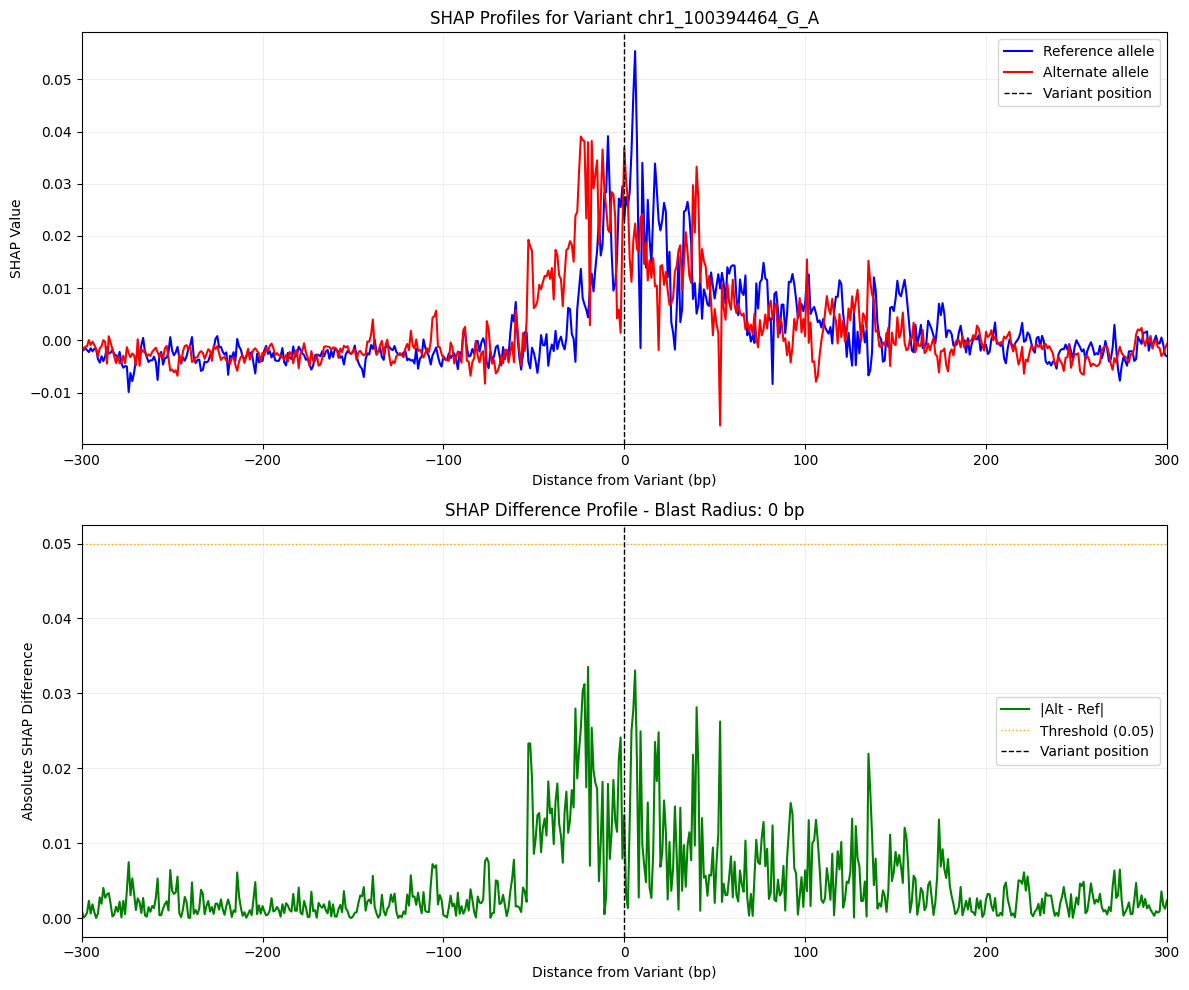

Variant ID: chr1_100394464_G_A
Reference allele index: 6
Alternate allele index: 7
Reference allele type: 0.0
Alternate allele type: 0.0
Blast Radius: 0 bp
Maximum difference: 0.0335
Number of affected positions (>0.05): 0
Blast radius: 0 bp


In [ ]:

# Example usage
if __name__ == "__main__":
    # Example file path - adjust as needed
    h5_file_path = "/gchm/cd4_chrombpnet/chrombpnet_model_b7/variant_contribution_scores/averaged_cd4_tcells_AJ_common_variants.shap.counts.h5"
    
    # First, inspect the structure
    print("=== File Structure ===")
    inspect_deepdish_structure(h5_file_path)
    
    print("\n=== Variant Analysis ===")
    # Analyze specific variants
    # Example 1: By variant ID
    try:
        blast_radius = analyze_by_variant_id(h5_file_path, "chr1_100394464_G_A", window_size=300)
        print(f"Blast radius: {blast_radius} bp")
    except Exception as e:
        print(f"Error analyzing by variant ID: {e}")
    
    # Example 2: By index
#    try:
#        blast_radius = analyze_by_index(h5_file_path, 0, window_size=300)
#        print(f"Blast radius: {blast_radius} bp")
#    except Exception as e:
#        print(f"Error analyzing by index: {e}")

Loaded data with 22880 total entries
SHAP data shape: (22880, 4, 2114)
Unique variants: 11440


<Figure size 1200x800 with 0 Axes>

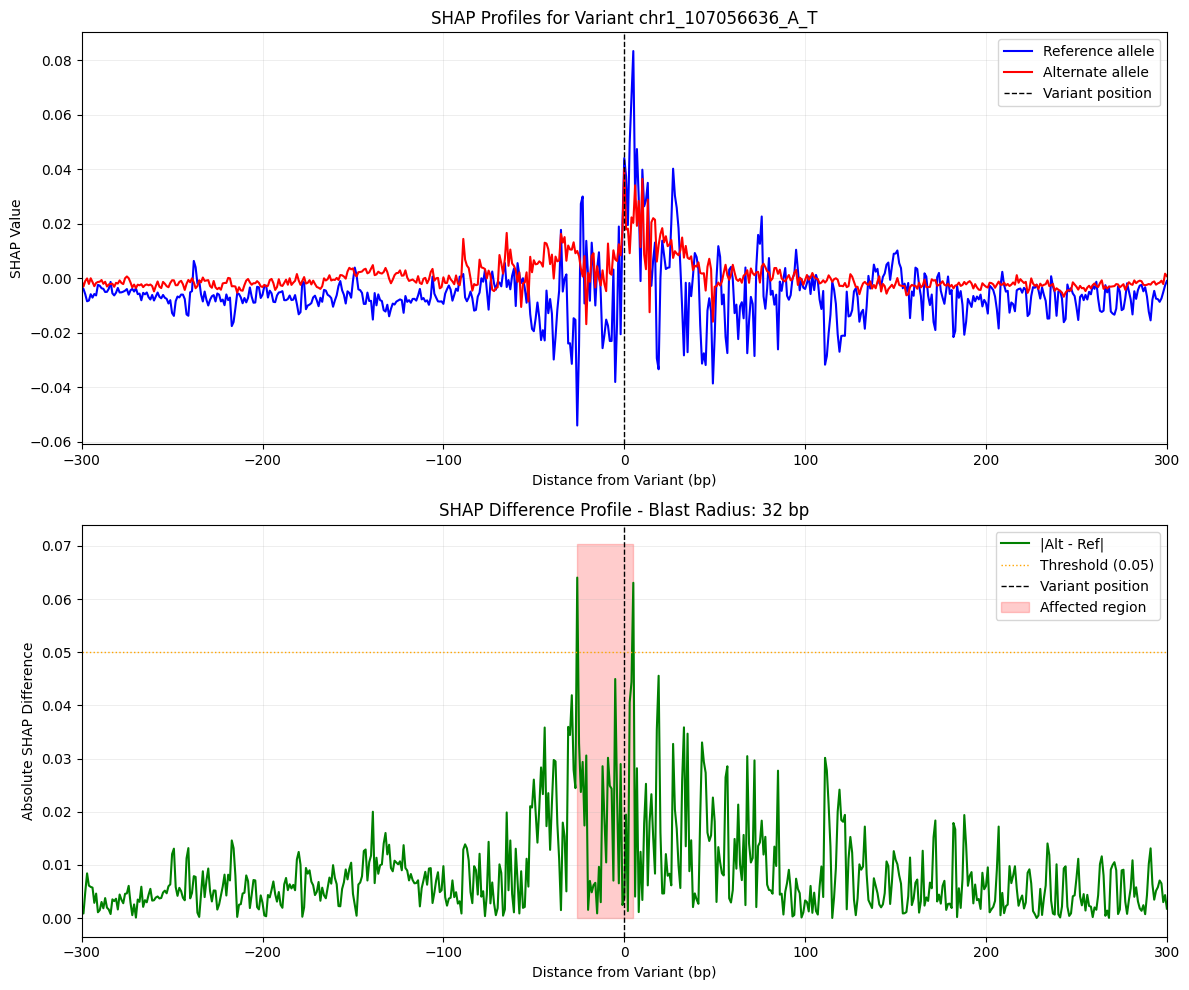

Variant ID: chr1_107056636_A_T
Reference allele index: 26
Alternate allele index: 27
Reference allele type: 0.0
Alternate allele type: 0.0
Blast Radius: 32 bp
Maximum difference: 0.0640
Number of affected positions (>0.05): 2
Blast radius: 32 bp


In [18]:
    try:
        blast_radius = analyze_by_variant_id(h5_file_path, "chr1_107056636_A_T", window_size=300)
        print(f"Blast radius: {blast_radius} bp")
    except Exception as e:
        print(f"Error analyzing by variant ID: {e}")



In [ ]:
import deepdish as dd
import numpy as np

# Read the entire file
h5_file_path="/gchm/cd4_chrombpnet/chrombpnet_model_b7/variant_prediction_scores/averaged_variant_prediction_scores.h5"
data = dd.io.load(h5_file_path)

In [2]:
data

{'observed': {'allele1_pred_counts': array([[  224.51733],
         [  259.5246 ],
         [15304.362  ],
         ...,
         [  838.1014 ],
         [  576.71216],
         [ 3061.0383 ]], dtype=float32),
  'allele1_pred_profiles': array([[ 0.77505803,  0.5066625 ,  0.70710546, ...,  0.32742637,
          -0.07399853,  0.08457527],
         [ 0.58896226,  0.7899711 ,  0.37397054, ...,  0.430054  ,
           0.4647366 ,  0.48364592],
         [-0.40811434, -0.32300004, -0.17183836, ...,  2.1873224 ,
           2.1700172 ,  2.1796699 ],
         ...,
         [ 2.1766117 ,  1.8490713 ,  1.6124531 , ...,  1.9248091 ,
           2.026905  ,  1.8533106 ],
         [ 0.4070093 ,  0.56424224,  1.1091087 , ..., -0.1031245 ,
          -0.17921276, -0.26956376],
         [-0.05750873, -0.14431338, -0.15353437, ...,  1.7071606 ,
           1.5461843 ,  1.4300088 ]], dtype=float32),
  'allele2_pred_counts': array([[  230.10898],
         [  257.6184 ],
         [15171.484  ],
         ...,
 

In [ ]:
import deepdish as dd
import numpy as np

# Read the entire file
h5_file_path="/gchm/cd4_chrombpnet/chrombpnet_model_b7/variant_prediction_scores/perfold_perchrom/fold_0/cd4_tcells_AJ_common_variants.chr1.variant_predictions.h5"
data = dd.io.load(h5_file_path)

In [4]:
data

{'observed': {'allele1_pred_counts': array([[  206.6404 ],
         [  276.14575],
         [15480.842  ],
         ...,
         [ 1800.5767 ],
         [24134.195  ],
         [21278.242  ]], dtype=float32),
  'allele1_pred_profiles': array([[ 0.42583227,  0.1708988 ,  0.39208674, ..., -0.00726342,
          -0.29221404, -0.1112175 ],
         [ 0.8061869 ,  1.2147659 ,  0.7558179 , ...,  0.26251101,
           0.2311449 ,  0.24290955],
         [-0.5995314 , -0.44291103, -0.47784805, ...,  1.9018128 ,
           2.0416713 ,  1.8832616 ],
         ...,
         [ 1.8716433 ,  2.1164765 ,  2.617803  , ...,  0.4243505 ,
           0.42178392,  0.42457104],
         [ 2.1521587 ,  2.1806402 ,  1.723772  , ...,  1.1191298 ,
           0.65026   ,  1.0642515 ],
         [ 3.223896  ,  3.112091  ,  3.1248655 , ...,  0.8412019 ,
           0.949249  ,  0.66028035]], dtype=float32),
  'allele2_pred_counts': array([[  210.80988],
         [  272.04517],
         [15088.119  ],
         ...,
 